# <center>Предсказание рейтинга вина
## Знакомство с данными

In [37]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

plt.style.use('dark_background')

In [3]:
data = pd.read_csv('data/winequality-red.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Attribute Information:

Input variables (based on physicochemical tests):
* 1 - fixed acidity
* 2 - volatile acidity
* 3 - citric acid
* 4 - residual sugar
* 5 - chlorides
* 6 - free sulfur dioxide
* 7 - total sulfur dioxide
* 8 - density
* 9 - pH
* 10 - sulphates
* 11 - alcohol

Output variable (based on sensory data):
* 12 - quality (score between 0 and 10)



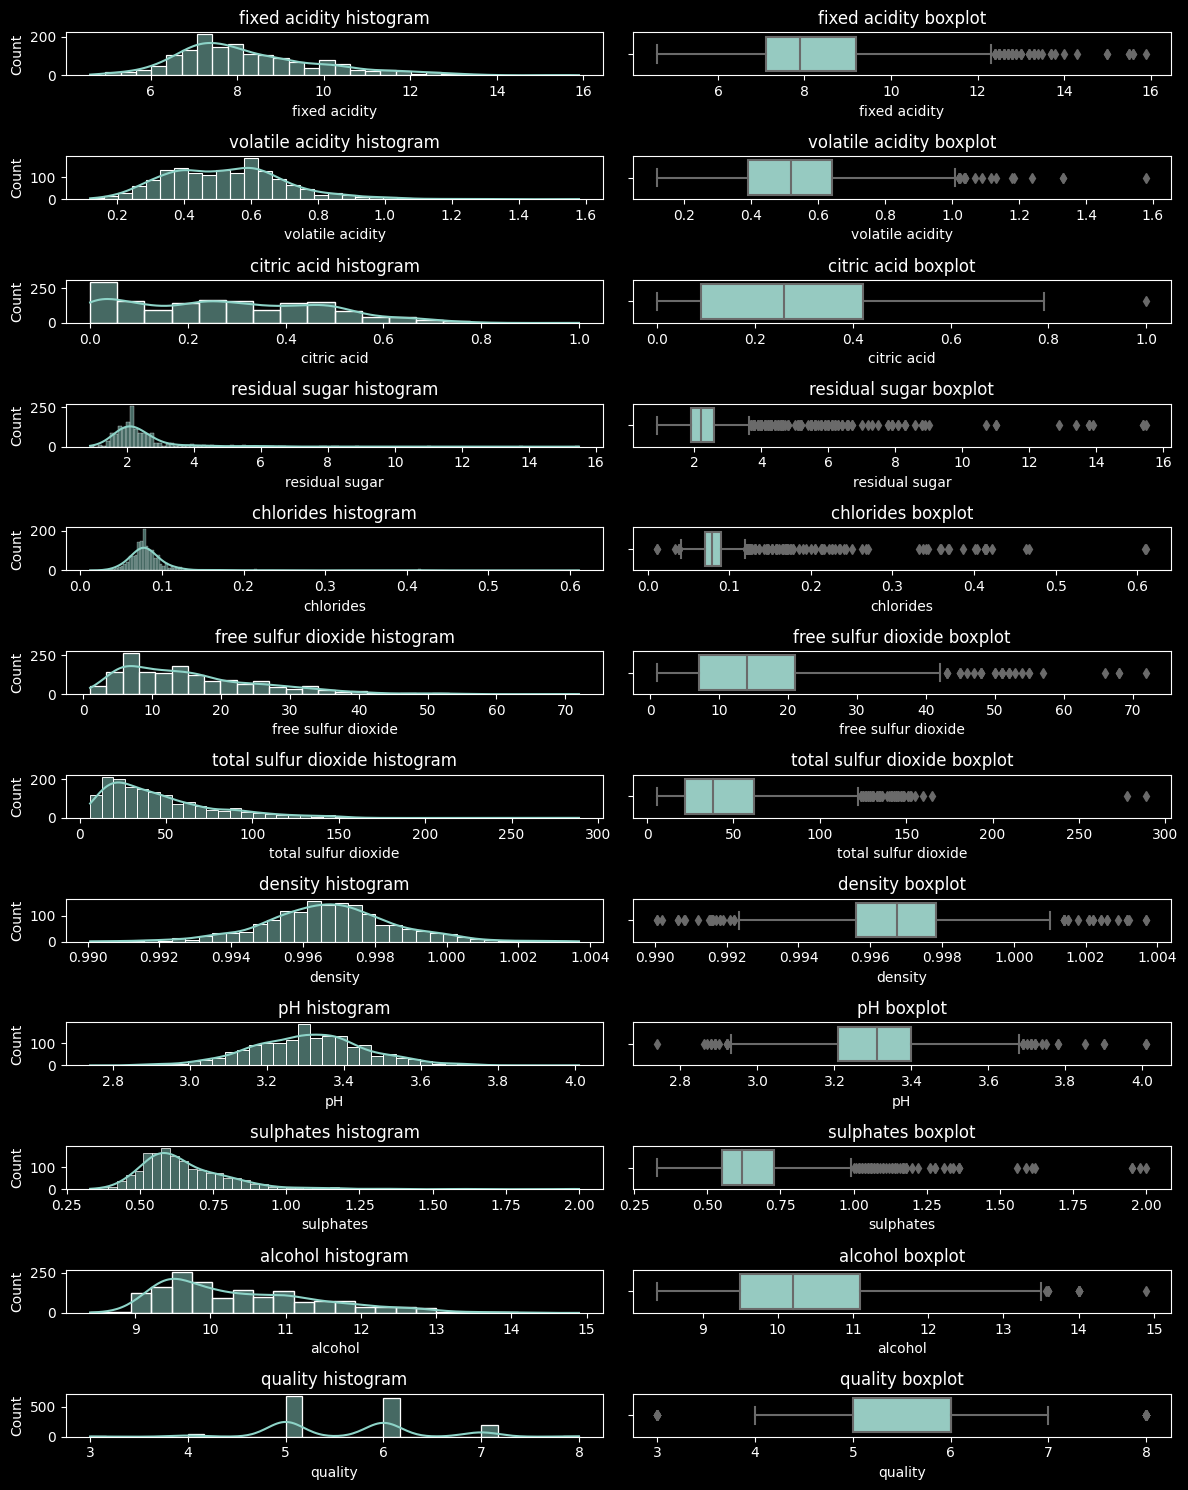

In [4]:
def make_histbox(data, features:list):
    fig, axs = plt.subplots(len(features), 2, figsize=(12, 15))
    for feature, row in zip(features, range(len(features))):
        ax, ay = axs[row, 0], axs[row, 1]
        sns.histplot(data, x=feature, ax=ax, kde=True)
        sns.boxplot(data, x=feature, ax=ay)
        ax.set_title(feature + ' histogram')
        ay.set_title(feature + ' boxplot')
    fig.tight_layout()
make_histbox(data, data.columns)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## EDA

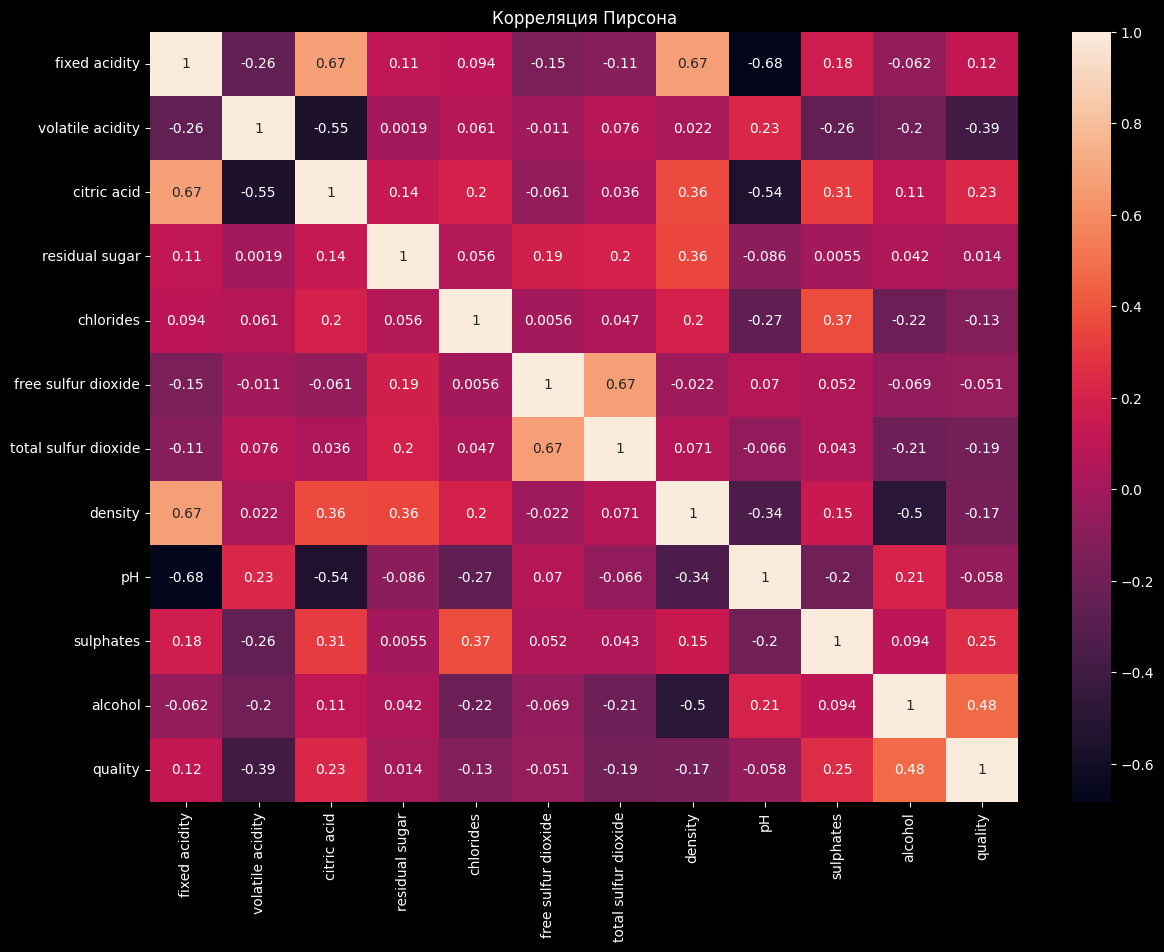

In [8]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, ax=ax).set_title('Корреляция Пирсона');

In [23]:
line_density = px.scatter(
    data,
    y='density',
    x='fixed acidity',
    template='plotly_dark',
    title='Зависимость плотности от показателя pH в разрезе качества вина',
    width=900,
    height=600,
    color='quality'
)
line_alc = px.scatter(
    data,
    y='alcohol',
    x='density',
    color='quality',
    template='plotly_dark',
    title='Зависимость содержания спирта от плотности в разрезе качества вина',
    width=900,
    height=600,
)
line_density.show()
line_alc.show()

## Построение моделей

In [25]:
X, y = data.drop(columns='quality'), data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1199, 11) (400, 11) (1199,) (400,)


### LogisticRegression

In [36]:
logreg_model = linear_model.LogisticRegression(class_weight='balanced', random_state=42, multi_class='multinomial', max_iter=10000).fit(X_train, y_train)

y_train_pred = logreg_model.predict(X_train)
y_test_pred = logreg_model.predict(X_test)

print('Train weighted F1-score:\n', metrics.classification_report(y_train, y_train_pred), sep='')
print('Test weighted F1-score:\n', metrics.classification_report(y_test, y_test_pred), sep='')

Train weighted F1-score:
              precision    recall  f1-score   support

           3       0.09      1.00      0.17         8
           4       0.10      0.40      0.16        40
           5       0.70      0.56      0.63       511
           6       0.62      0.28      0.39       478
           7       0.33      0.44      0.38       149
           8       0.09      0.85      0.15        13

    accuracy                           0.44      1199
   macro avg       0.32      0.59      0.31      1199
weighted avg       0.59      0.44      0.48      1199

Test weighted F1-score:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.09      0.38      0.14        13
           5       0.71      0.52      0.60       170
           6       0.56      0.27      0.36       160
           7       0.34      0.48      0.40        50
           8       0.06      0.40      0.10         5

    accuracy                

### RandomForestClassifier

In [101]:
scv = StratifiedKFold(n_splits=5)

def objective(trial:optuna.Trial, X=X_train, y=y_train):
    params = dict(
        max_depth=trial.suggest_int('max_depth', 6, 8),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 30),
        n_estimators=trial.suggest_int('n_estimators', 400, 500),
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy'])
    )
    model = ensemble.RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    score = cross_val_score(model, X, y, cv=scv, n_jobs=-1, scoring='f1_weighted').mean()
    return score

study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(objective, n_trials=50)
print('Best params:', study_rf.best_params)
print('Best score:', study_rf.best_value)

[I 2023-04-06 21:49:26,131] A new study created in memory with name: RandomForestClassifier
[I 2023-04-06 21:49:26,762] Trial 0 finished with value: 0.5475055294232105 and parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 428, 'criterion': 'gini'}. Best is trial 0 with value: 0.5475055294232105.
[I 2023-04-06 21:49:27,369] Trial 1 finished with value: 0.5021677052749867 and parameters: {'max_depth': 6, 'min_samples_leaf': 22, 'min_samples_split': 15, 'n_estimators': 433, 'criterion': 'gini'}. Best is trial 0 with value: 0.5475055294232105.
[I 2023-04-06 21:49:27,999] Trial 2 finished with value: 0.49474410241227573 and parameters: {'max_depth': 6, 'min_samples_leaf': 26, 'min_samples_split': 28, 'n_estimators': 471, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5475055294232105.
[I 2023-04-06 21:49:28,652] Trial 3 finished with value: 0.5914443442558672 and parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n

Best params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 470, 'criterion': 'entropy'}
Best score: 0.6247592104220105


In [102]:
best_rf = ensemble.RandomForestClassifier(
    **study_rf.best_params,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
).fit(X_train, y_train)

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print('Train report:\n', metrics.classification_report(y_train, y_train_pred), sep='')
print('Test report:\n', metrics.classification_report(y_test, y_test_pred, zero_division=0), sep='')

Train report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         8
           4       0.98      1.00      0.99        40
           5       0.88      0.92      0.90       511
           6       0.92      0.82      0.87       478
           7       0.81      0.97      0.88       149
           8       1.00      1.00      1.00        13

    accuracy                           0.89      1199
   macro avg       0.93      0.95      0.94      1199
weighted avg       0.89      0.89      0.89      1199

Test report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        13
           5       0.73      0.78      0.75       170
           6       0.63      0.62      0.63       160
           7       0.52      0.62      0.56        50
           8       0.50      0.20      0.29         5

    accuracy                           0.66       

### GradientBoostingClassifier

In [115]:
def objective(trial:optuna.Trial, X=X_train, y=y_train):
    params = dict(
        max_depth=trial.suggest_int('max_depth', 2, 5),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 30),
        n_estimators=trial.suggest_int('n_estimators', 10, 35),
        criterion=trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5),
    )
    model = ensemble.GradientBoostingClassifier(
        **params,
        random_state=42,
        # n_estimators=10
    )
    score = cross_val_score(model, X, y, cv=scv, n_jobs=-1, scoring='f1_weighted').mean()
    return score

study_gb = optuna.create_study(study_name='GradientBoostingClassifier', direction='maximize')
study_gb.optimize(objective, n_trials=50)
print('Best params:', study_gb.best_params)
print('Best score:', study_gb.best_value)

[I 2023-04-06 22:02:40,915] A new study created in memory with name: GradientBoostingClassifier
[I 2023-04-06 22:02:41,461] Trial 0 finished with value: 0.6424353463001021 and parameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 23, 'n_estimators': 28, 'criterion': 'friedman_mse', 'learning_rate': 0.13660423046320194}. Best is trial 0 with value: 0.6424353463001021.
[I 2023-04-06 22:02:41,811] Trial 1 finished with value: 0.5919555517499389 and parameters: {'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 18, 'n_estimators': 28, 'criterion': 'friedman_mse', 'learning_rate': 0.04653779539682174}. Best is trial 0 with value: 0.6424353463001021.
[I 2023-04-06 22:02:42,139] Trial 2 finished with value: 0.6439766049453974 and parameters: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 14, 'n_estimators': 19, 'criterion': 'friedman_mse', 'learning_rate': 0.4259423074544933}. Best is trial 2 with value: 0.6439766049453974.
[I 2023-04-06 22:02:42,3

Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 26, 'criterion': 'squared_error', 'learning_rate': 0.1856208199257701}
Best score: 0.6601850877785218


In [116]:
best_gb = ensemble.GradientBoostingClassifier(
    **study_gb.best_params,
    random_state=42,
    # n_estimators=35
).fit(X_train, y_train)

y_train_pred = best_gb.predict(X_train)
y_test_pred = best_gb.predict(X_test)

print('Train report:\n', metrics.classification_report(y_train, y_train_pred), sep='')
print('Test report:\n', metrics.classification_report(y_test, y_test_pred), sep='')

Train report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         8
           4       1.00      0.97      0.99        40
           5       0.98      0.98      0.98       511
           6       0.96      0.98      0.97       478
           7       1.00      0.97      0.98       149
           8       1.00      1.00      1.00        13

    accuracy                           0.98      1199
   macro avg       0.99      0.98      0.99      1199
weighted avg       0.98      0.98      0.98      1199

Test report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.14      0.08      0.10        13
           5       0.74      0.74      0.74       170
           6       0.60      0.71      0.65       160
           7       0.60      0.36      0.45        50
           8       0.25      0.20      0.22         5

    accuracy                           0.65       

In [117]:
param_imp = optuna.visualization.plot_param_importances(study_rf)
opt_hist = optuna.visualization.plot_optimization_history(study_rf)
feature_importances_df = pd.DataFrame(data=best_rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)
feature_importances = px.bar(
    feature_importances_df,
    x='importance',
    template='plotly_dark',
    width=900,
    height=600,
    color=feature_importances_df.index,
    title='Feature importances',
    labels={'index': 'feature'}
)
param_imp.update_layout(template='plotly_dark')
opt_hist.update_layout(template='plotly_dark')
feature_importances.show()
param_imp.show()
opt_hist.show()

## Вывод
`RandomForestClassifier` показал наилучший результат метрики $weighted \space F_1-score$, равный $0.65$